In [29]:
# import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ANN module
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Loss
from sklearn.metrics import mean_squared_error

# data_path
curren_path = os.getcwd()
boston_file_path = 'c:/Users/taehy/Desktop/새 폴더/data/boston.csv'

In [30]:
# load_data
df = pd.read_csv(boston_file_path)
df.rename(columns={'MEDV' : 'Price'}, inplace = True)
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [31]:
## scaling

# features data to numpy array
X = df.drop('Price', axis = 1).to_numpy()
y = df['Price'].to_numpy().reshape((-1, 1))

# scaling
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
scaler.fit(y)
y = scaler.transform(y)

In [32]:
# torch의 Datasets 상속
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

In [33]:
# split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
print(X_train.shape, y_train.shape, X_test.shape, y_train.shape)

# create batch type of train_data/test_data
trainsets = TensorData(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size = 32, shuffle =True)

testsets = TensorData(X_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size = 32, shuffle=False)

(253, 13) (253, 1) (253, 13) (253, 1)


In [34]:
# Create Model
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias = True) # input layer -> hidden layer1
        self.fc2 = nn.Linear(50, 30, bias = True) # hidden layer1 -> hidden layer2
        self.fc3 = nn.Linear(30, 1, bias = True) # hidden layer2 -> output layer
        self.dropout = nn.Dropout(0.2) # 연산이 정의 될 때마다 20% 비율로 랜덤하게 노들르 없앰.

    def forward(self, x): # 모델 연산순서 정의
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x

In [35]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-7)    

In [36]:
loss_ = [] # loss list
n = len(trainloader)

for epoch in range(400):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, values = data
        optimizer.zero_grad() # init optimizer

        outputs = model(inputs) # predict data
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step() # update weights
        running_loss += loss.item()

    loss_.append(running_loss/n) # MSE


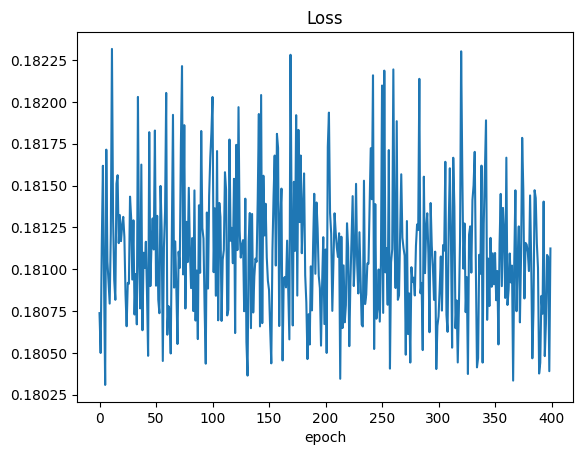

In [37]:
# loss plot
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

In [39]:
train_rmse = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
test_rmse = evaluation(testloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:0.4255422353744507
test rmse:0.4537569582462311


In [40]:
predictions

NameError: name 'predictions' is not defined

In [41]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)
      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  return predictions